# Galaxy Classification with Vision Transformer (Pytorch)

**Hugging Face's Vision Transformer implementation**

- https://huggingface.co/docs/transformers/model_doc/vit
- https://github.com/huggingface/transformers/blob/v4.14.1/src/transformers/models/vit/modeling_vit.py

**GalaxyZoo 2 Data**

- https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge


**ViT papers**

- https://arxiv.org/abs/2010.11929

- https://arxiv.org/abs/2110.01024

- https://arxiv.org/abs/2005.00928


**Coding references**

- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

- https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

- https://github.com/jeonsworld/ViT-pytorch/blob/main/visualize_attention_map.ipynb


## Prerequisites

1. Link to Google Drive
2. Upload vit predictions csv file to the workspace

## ViT Model parameters

Model used: 010822B (87.45/84.91/85.00)

## Check GPU

In [ ]:
!nvidia-smi -L

## Install HuggingFace Vision Transformer (ViT)

In [ ]:
!pip install transformers

## Import Libraries

In [3]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import os
import zipfile
from copy import deepcopy

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# vision transformer
from transformers import ViTModel, ViTConfig, ViTForImageClassification

cuda:0


In [4]:
torch.manual_seed(0)

## Unzip images from Google Drive


In [5]:
## The unzipping function
def unzipping(zip_file_name, dest_dir):
    """
    Arguments
        zip_file_name: (str) the file name of the zip file
        dest_dir: (str) the name of the destination folder
    """
    # check if the destination folder exists. Create one if not.
    #if not os.path.exists(dest_dir):
    #    os.makedirs(dest_dir)
    
    # unzipping
    zip_f = zipfile.ZipFile(zip_file_name, 'r')
    zip_f.extractall(path=dest_dir)
    zip_f.close()

In [7]:
## directory on Google Drive
datasets_dir = 'drive/MyDrive/gz2_datasets'

## Unzip training, validation, and test images
unzipping(os.path.join(datasets_dir, 'images_test.zip'), './')
unzipping(os.path.join(datasets_dir, 'images_train.zip'), './')
unzipping(os.path.join(datasets_dir, 'images_valid.zip'), './')

## Initialize Vision Transformer (HuggingFace ViT_Base)

In [22]:
"""
Create ViT
"""
## Vision Transformer
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

# change the last layer
model.classifier = nn.Linear(in_features=768, out_features=8, bias=True)

print("Number of trainable parameters: {}".format(sum(param.numel() for param in model.parameters() if param.requires_grad)))

"""
Load Pretrained Weights (Model 010822B)
"""

pth_filename = 'gz2_hug_vit_010822B.pth'
model.load_state_dict(torch.load(os.path.join('drive/MyDrive/gz2_datasets', pth_filename)))

Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Number of trainable parameters: 85804808


<All keys matched successfully>

## Load galaxy labels and predictions

In [9]:
df = pd.read_csv(os.path.join('drive/MyDrive/gz2_datasets', 'hug_vit_010822B_all_predictions_no_aug.csv'))
df.head()

,GalaxyID,class,pred
0,247233,5,1
1,98167,5,5
2,85016,4,4
3,95326,3,3
4,81017,2,3


## Display Attention Maps

In [86]:
def vit_attention_map_gid(model, gid_list, df, attn_threshold=0):
    """
    Extract the attention map of ViT from random sampled images
    Args:
        model: vit model
        gid_list:  a list of galaxy IDs
        df: the dataframe containing the true/predicted labels
        attn_threshold: threshold below which attention is truncated to 0
    """
    assert 0 <= attn_threshold <= 1

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # galaxy categories
    gxy_labels = ['Round Elliptical', 'In-between Elliptical','Cigar-shaped Elliptical',
                  'Edge-on Spiral','Barred Spiral','Unbarred Spiral','Irregular','Merger']

    # move model to gpu
    model = model.to(device)
    model.eval()

    ## create input tensor
    for i, gid in enumerate(gid_list):

        # get image file
        try:
            image = Image.open(os.path.join('images_train', str(gid) + '.jpg'))
        except FileNotFoundError:
            try:
                image = Image.open(os.path.join('images_valid', str(gid) + '.jpg'))
            except FileNotFoundError:
                try:
                    image = Image.open(os.path.join('images_test', str(gid) + '.jpg'))
                except FileNotFoundError:
                    print("gid #{} does not exist".format(gid))
    
        # image transfrorm
        data_transform = transform = transforms.Compose([transforms.CenterCrop(224),
                                                         transforms.ToTensor(),
                                                         transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
        image = torch.unsqueeze(data_transform(image), 0)  # torch tensor
        image = image.to(device)

        # true label
        true_cls = int(df[df['GalaxyID']==gid]['class'])  # int

        # prediction
        pred_cls = int(df[df['GalaxyID']==gid]['pred'])  # int

        with torch.no_grad():
            return_dict = model.config.use_return_dict
            outputs = model.vit(image, output_attentions=True, output_hidden_states=True, return_dict=return_dict)

            fig, axs = plt.subplots(3, 6, figsize=(15, 8))
            axs[0][2].axis('off')
            axs[0][2].axis('off')


            # image (need to convert to cv2 format)
            img = image[0].cpu().numpy()
            img *= 0.5
            img += 0.5
            img = np.transpose(img, (1, 2, 0))  # (224, 224, 3)
            img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            
            axs[0][0].imshow(img)
            axs[0][0].set_title("ID:{}\nClass: {}\nPred: {}".format(gid, gxy_labels[true_cls], gxy_labels[pred_cls]), fontsize=10)
            axs[0][0].axis('off')

            # attention averaged over all heads
            attn_matrices = []
            for layer_i in range(12):
                # average all heads
                attn = np.mean(outputs[2][layer_i][0].cpu().numpy(), axis=0)  # (197, 197)
                # add residual
                attn += np.identity(attn.shape[0])  # (197, 197)
                # normalize
                attn = attn/2  # (197, 197)
                # recurvie multiply the attention matrices
                if layer_i != 0:
                    attn = np.matmul(attn, attn_matrices[layer_i-1])
                # append to list
                attn_matrices.append(attn)
                # attn map
                attn_map = np.array(attn[0, 1:]).reshape(14, 14)
                # normalize
                attn_map = attn_map / attn_map.max()
                # attn mask
                attn_mask = cv2.resize(attn_map, (224, 224))[..., None]
                attn_mask = np.concatenate((attn_mask, attn_mask, attn_mask), axis=2)
            
            axs[0][1].imshow(attn_mask[..., 0], cmap='jet')
            axs[0][1].set_title("Attn (avg)", fontsize=10)
            axs[0][1].axis('off')

            ## attention of individual heads
            head_attn_matrices = [[] for _ in range(12)]
            for h_idx in range(12):
                for layer_i in range(12):
                    # individual head
                    attn = outputs[2][layer_i][0].cpu().numpy()[h_idx]  # (197, 197)
                    # add residual
                    attn += np.identity(attn.shape[0])  # (197, 197)
                    # normalize
                    attn = attn/2  # (197, 197)
                    # recurvie multiply the attention matrices
                    if layer_i != 0:
                        attn = np.matmul(attn, head_attn_matrices[h_idx][layer_i-1])
                    # append to list
                    head_attn_matrices[h_idx].append(attn)
                # attn map
                attn_map = np.array(attn[0, 1:]).reshape(14, 14)
                # normalize
                if attn_threshold == 0:
                    attn_map = attn_map / attn_map.max()
                # attn mask
                attn_mask = cv2.resize(attn_map, (224, 224))[..., None]
                attn_mask = np.where(attn_mask > attn_threshold, attn_mask, 0)
                attn_mask = np.concatenate((attn_mask, attn_mask, attn_mask), axis=2)

                axs[1+h_idx//6, h_idx%6].imshow(attn_mask[..., 0], cmap='jet')
                axs[1+h_idx//6, h_idx%6].set_title("Head #{}".format(1+h_idx), fontsize=10)
                axs[1+h_idx//6, h_idx%6].axis('off')


            ## Apply thresholds on each head and overlay together
            axs[0][3].axis('off')
            axs[0][4].axis('off')
            axs[0][5].axis('off')

        plt.show()

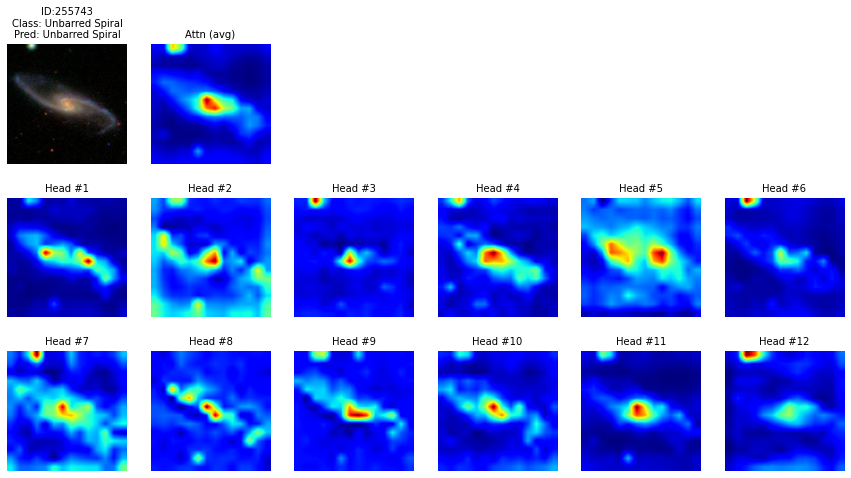

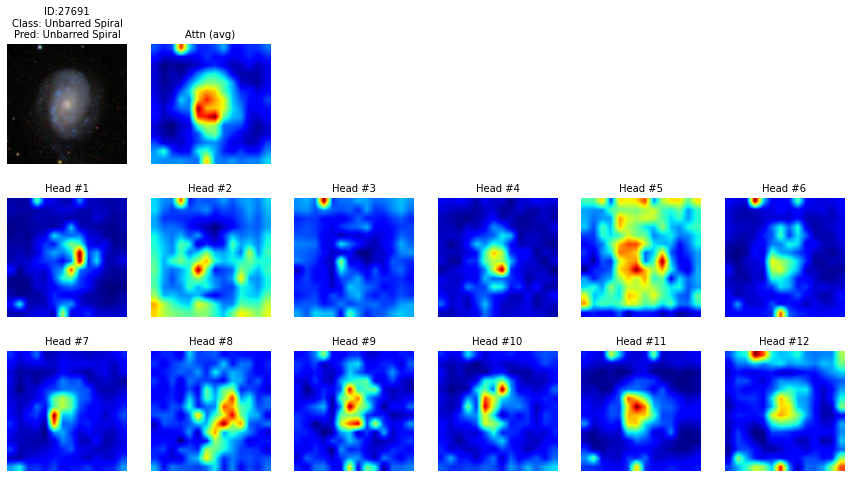

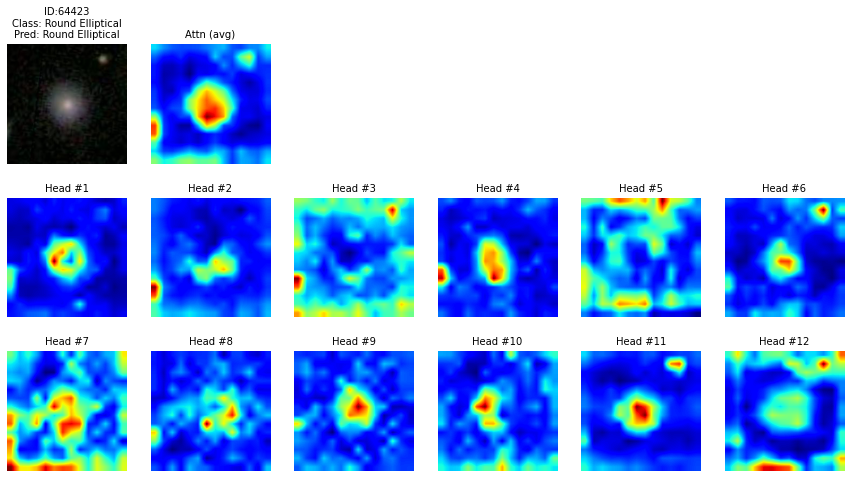

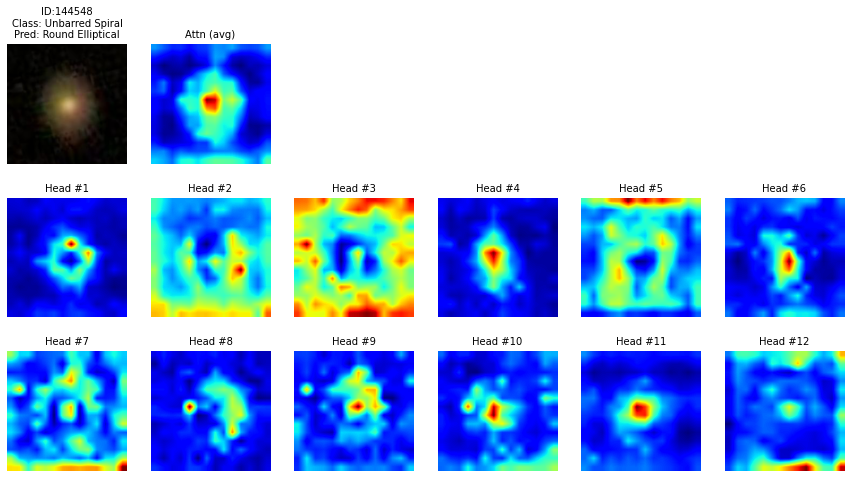

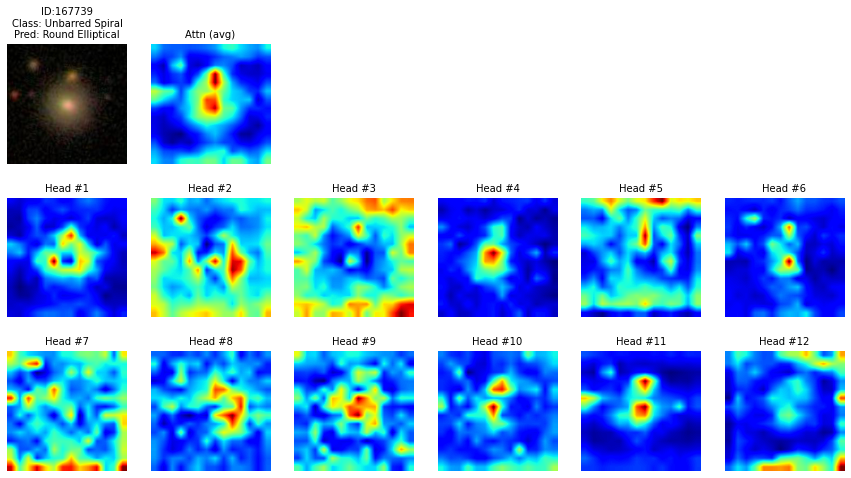

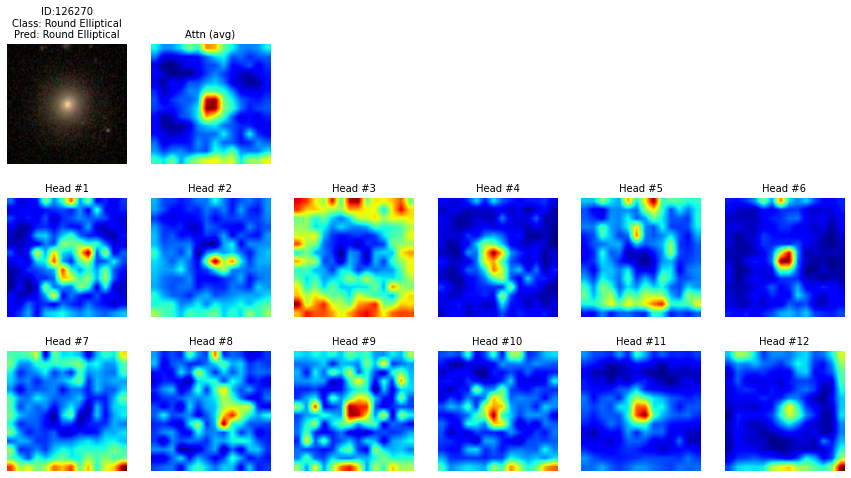

In [88]:
# figure 5A
vit_attention_map_gid(model, [255743, 27691, 64423], df, attn_threshold=0)
vit_attention_map_gid(model, [144548, 167739, 126270], df, attn_threshold=0)

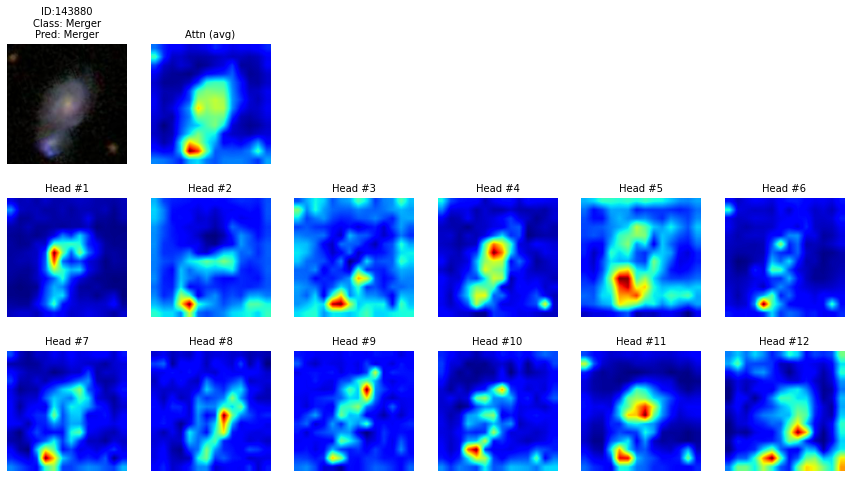

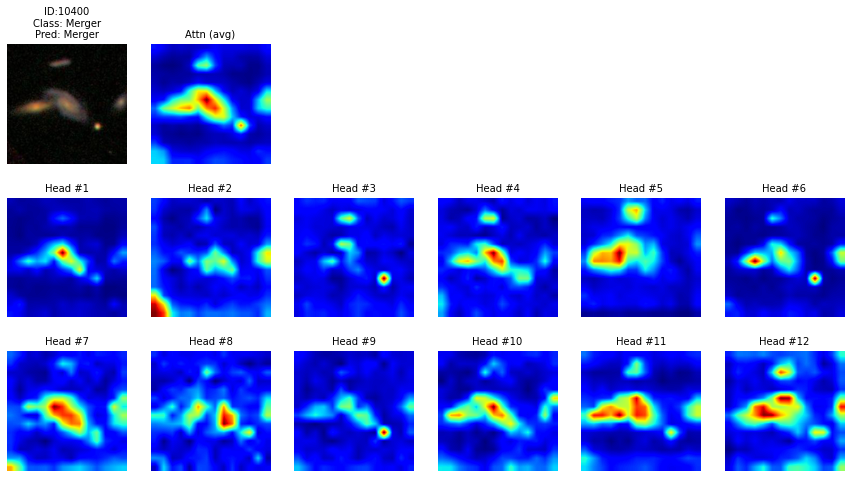

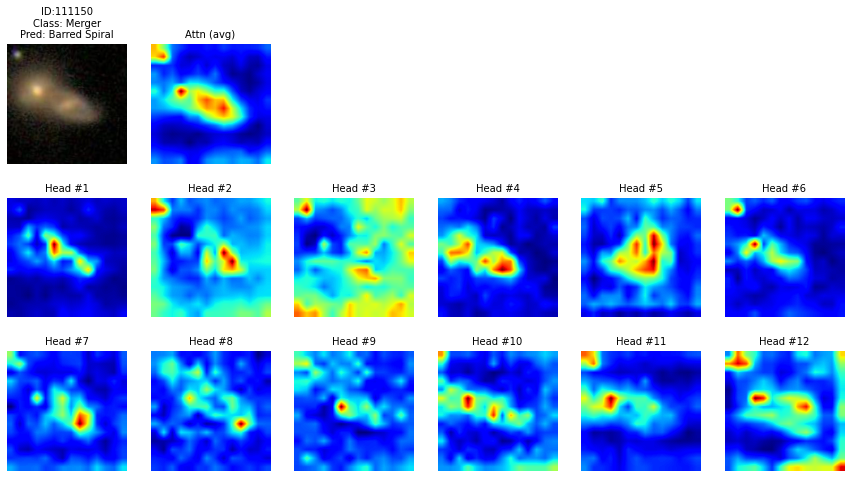

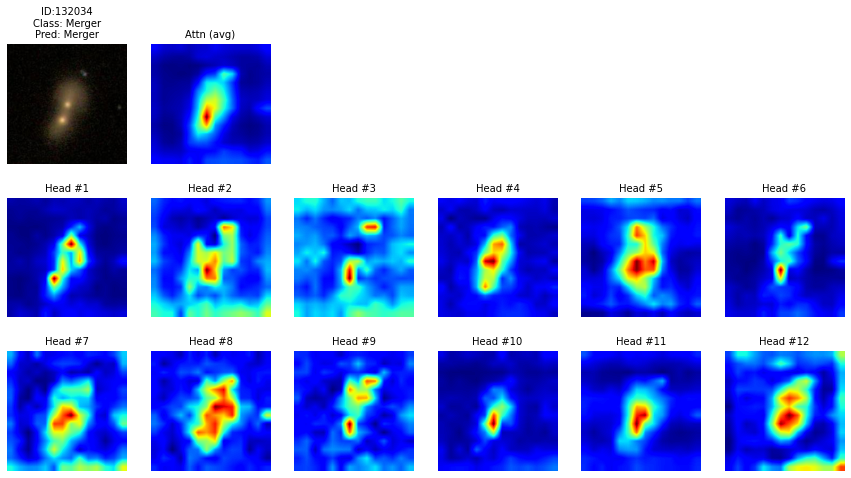

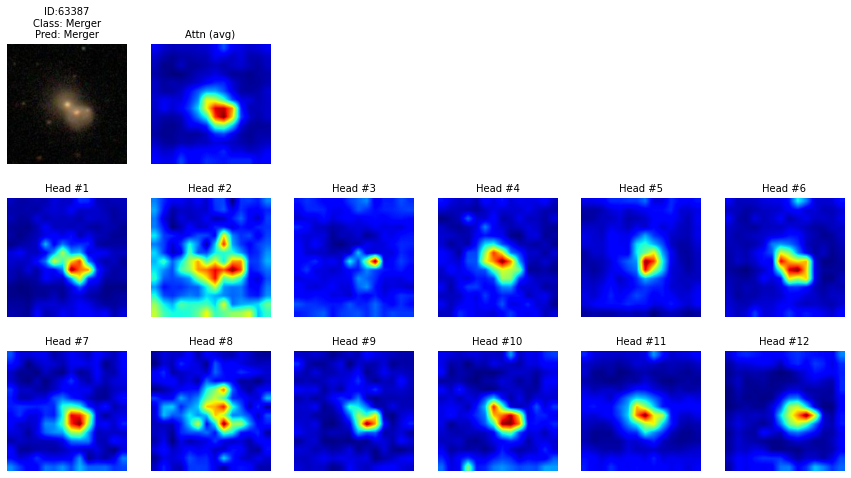

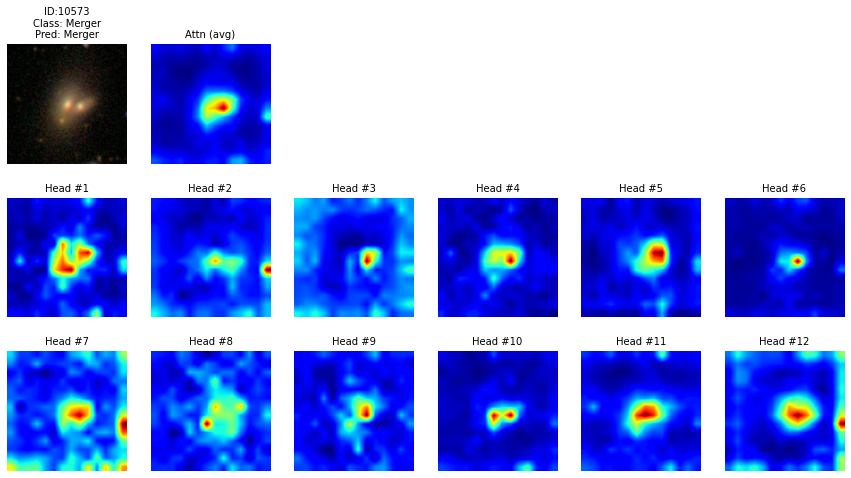

In [89]:
# figure 5B
vit_attention_map_gid(model, [143880, 10400, 111150], df, attn_threshold=0)
vit_attention_map_gid(model, [132034, 63387, 10573], df, attn_threshold=0)